# Prerequisites

In [1]:
%load_ext autoreload
%autoreload 2

import warnings

import cv2
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import selective_search as ss
from box_ops import nms
from data import WasteSet, get_waste, standardize_inv
from model import get_resnet
from selectivesearch import SelectiveSearch
from utils import show_annotation, show_cmap

# Load ResNet

In [2]:
# model = get_resnet(18, 2)
# print(model)

# Selective Search

In [3]:
train_dataset, _, _, _, _, _ = get_waste(8,
                                         num_workers=0,
                                         data_augmentation=True,
                                         supercategories=True)

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.19s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


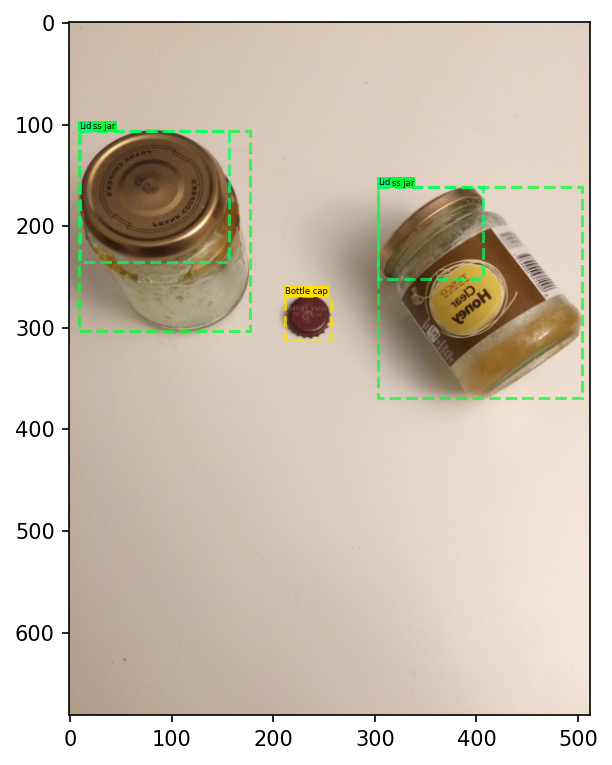

In [4]:
im, target = train_dataset[0]
im, _ = standardize_inv(im, None)
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=150)
ax.imshow(np.moveaxis(im.numpy(), 0, 2))
show_annotation(target, ax, names=train_dataset.cat_names)

In [5]:
# warnings.filterwarnings('ignore')
# # Propose boxes
# boxes = ss.selective_search(
#     (np.moveaxis(im.numpy(), 0, 2) * 255).astype(np.uint8),
#     mode='single',
#     random_sort=True)

# # boxes = ss.selective_search(
# #     (np.moveaxis(im.numpy(), 0, 2) * 255).astype(np.uint8), mode='fast')

# # Filter box proposals
# boxes_filter = ss.box_filter(boxes, min_size=20, topN=80)

# boxes_filter, _ = nms(boxes_filter)

# # draw rectangles on the original image
# fig, ax = plt.subplots(figsize=(6, 6))
# ax.imshow(np.moveaxis(im.numpy(), 0, 2))
# for x1, y1, x2, y2 in boxes_filter:
#     bbox = mpatches.Rectangle((x1, y1), (x2 - x1), (y2 - y1),
#                               fill=False,
#                               edgecolor='red',
#                               linewidth=1)
#     ax.add_patch(bbox)

# plt.axis('off')
# plt.show()

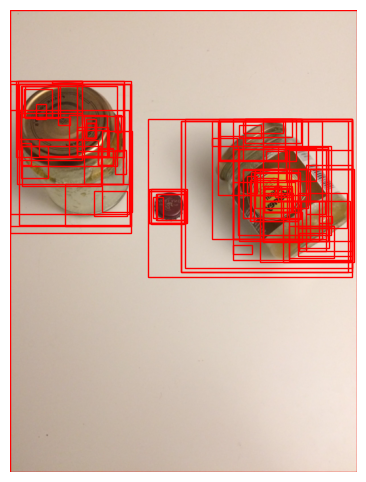

In [6]:
# https://github.com/opencv/opencv_contrib/blob/master/modules/ximgproc/samples/selectivesearchsegmentation_demo.py
# Mode ('s', 'f', 'q')
mode = 'f'

cv2.setUseOptimized(True)
cv2.setNumThreads(8)

gs = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
gs.setBaseImage((np.moveaxis(im.numpy(), 0, 2) * 255).astype(np.uint8))

if (mode == 's'):
    gs.switchToSingleStrategy()

elif (mode == 'f'):
    gs.switchToSelectiveSearchFast()

elif (mode == 'q'):
    gs.switchToSelectiveSearchQuality()
else:
    raise

boxes = gs.process()

# boxes, _ = nms(boxes)

# draw rectangles on the original image
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(np.moveaxis(im.numpy(), 0, 2))
for x, y, w, h in boxes[:100]:
    bbox = mpatches.Rectangle((x, y), w, h,
                              fill=False,
                              edgecolor='red',
                              linewidth=1)
    ax.add_patch(bbox)

plt.axis('off')
plt.show()

# Edgeboxes

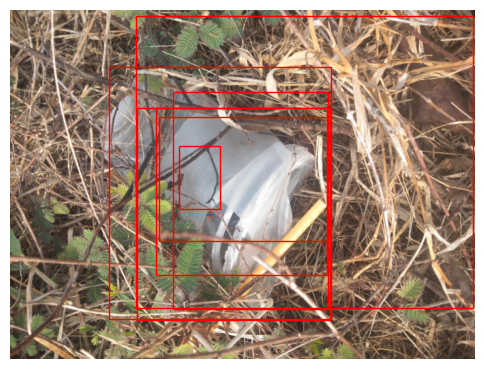

In [82]:
# https://stackoverflow.com/questions/54843550/edge-box-detection-using-opencv-python

model = './model.yml.gz'

edge_detection = cv2.ximgproc.createStructuredEdgeDetection(model)
edges = edge_detection.detectEdges(np.moveaxis(im.numpy(), 0, 2))
# edges = edge_detection.detectEdges((np.moveaxis(im.numpy(), 0, 2) * 255).astype(np.uint8))

orimap = edge_detection.computeOrientation(edges)
edges = edge_detection.edgesNms(edges, orimap)

edge_boxes = cv2.ximgproc.createEdgeBoxes()
edge_boxes.setMaxBoxes(10)
boxes, scores = edge_boxes.getBoundingBoxes(edges, orimap)

boxes, scores = nms(boxes, scores)

# draw rectangles on the original image
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(np.moveaxis(im.numpy(), 0, 2))
for x, y, w, h in boxes:
    bbox = mpatches.Rectangle((x, y), w, h,
                              fill=False,
                              edgecolor='red',
                              linewidth=1)
    ax.add_patch(bbox)

plt.axis('off')
plt.show()

# Selective search module unit test

In [86]:
ss = SelectiveSearch(mode='f', nkeep=200)

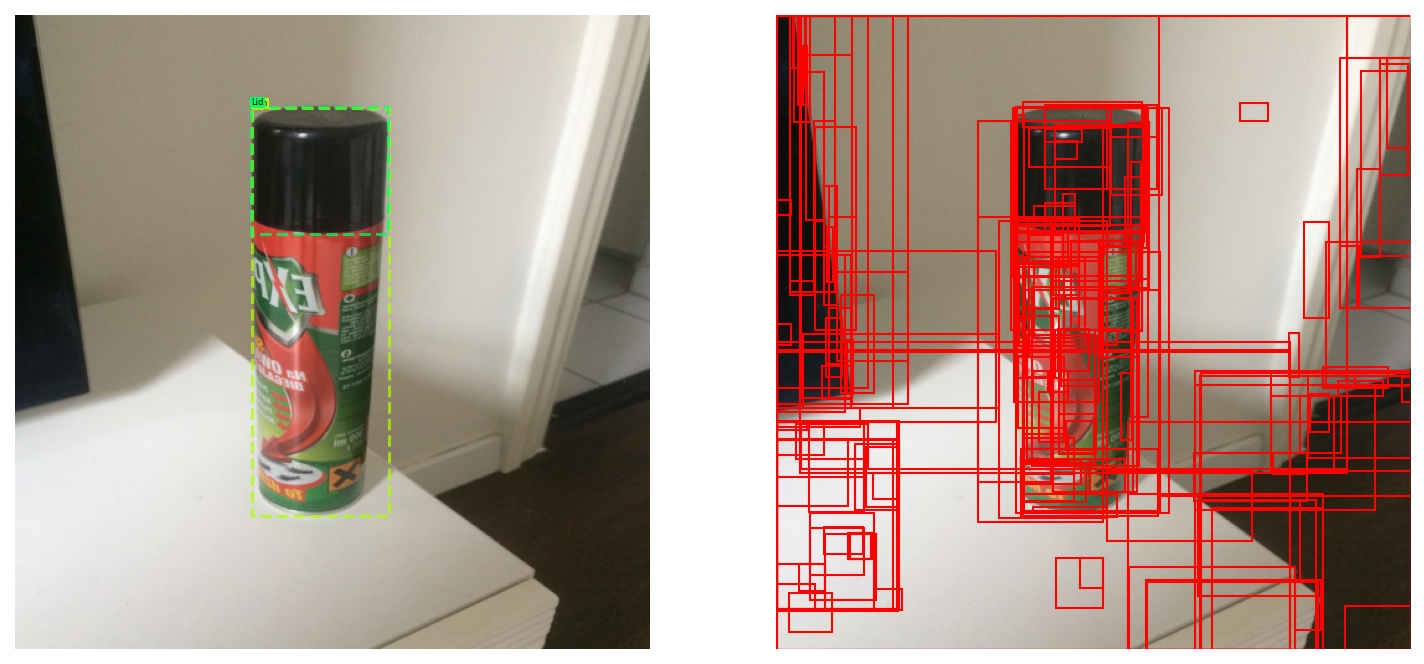

In [93]:
im, target = train_dataset[20]
im, _ = standardize_inv(im, None)
boxes = ss((np.moveaxis(im.numpy(), 0, 2) * 255).astype(np.uint8))

# draw rectangles on the original image
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6), dpi=150)
ax0.imshow(np.moveaxis(im.numpy(), 0, 2))
show_annotation(target, ax0, names=train_dataset.cat_names)
ax1.imshow(np.moveaxis(im.numpy(), 0, 2))
for x, y, w, h in boxes:
    bbox = mpatches.Rectangle((x, y), w, h,
                              fill=False,
                              edgecolor='red',
                              linewidth=1)
    ax1.add_patch(bbox)

ax0.axis('off')
ax1.axis('off')
plt.show()